**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from lightly.loss import NTXentLoss
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres fine tuning
LEARNING_RATE = 0.001
EPOCHS = 60
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No_Finding'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


# **Step 6: Data Processing Part 2**

**Define Dataset for ChestX-ray14 images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for ChestX-ray14 images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df) # TODO

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [10]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

# **Step 7: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [12]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load ResNet50 model with pre-trained weights
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        print(self.base_model)

        # Replace the classification head to match the number of disease labels
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

MultiLabelClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

**Use Multiple GPUs**

In [13]:
# Freeze all layers except the classifier
for param in model.base_model.parameters():
    param.requires_grad = False
for param in model.base_model.fc.parameters():
    param.requires_grad = True

**Define Loss Function and Optimizer**

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# **Step 8: Train the Model**

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # --- Gradual Unfreezing ---
        # After 5 epochs, unfreeze layer4
        if epoch == 4:
            print("Unfreezing layer4...")
            for param in model.base_model.layer4.parameters():
                param.requires_grad = True
            # Re-create optimizer with parameter groups: lower LR for layer4
            optimizer = optim.Adam([
                {"params": model.base_model.layer4.parameters(), "lr": 1e-4},
                {"params": model.base_model.fc.parameters(), "lr": 1e-3}
            ])
        
        # After 10 epochs, unfreeze layer3
        if epoch == 9:
            print("Unfreezing layer3...")
            for param in model.base_model.layer3.parameters():
                param.requires_grad = True
            optimizer = optim.Adam([
                {"params": model.base_model.layer3.parameters(), "lr": 1e-5},
                {"params": model.base_model.layer4.parameters(), "lr": 1e-5},
                {"params": model.base_model.fc.parameters(), "lr": 1e-4}
            ])

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/60:   0%|          | 0/2246 [00:00<?, ?it/s]

Epoch 1/60: 100%|██████████| 562/562 [00:35<00:00, 15.63it/s, Loss=0.158]


Epoch 1/60 | Training Loss: 0.2084 | Validation Loss: 0.2087 | Mean Validation AUC: 0.7275


Epoch 2/60: 100%|██████████| 562/562 [00:34<00:00, 16.06it/s, Loss=0.163]


Epoch 2/60 | Training Loss: 0.2050 | Validation Loss: 0.2117 | Mean Validation AUC: 0.7362


Epoch 3/60: 100%|██████████| 562/562 [00:18<00:00, 29.66it/s, Loss=0.122]


Epoch 3/60 | Training Loss: 0.2036 | Validation Loss: 0.2011 | Mean Validation AUC: 0.7349


Epoch 4/60: 100%|██████████| 562/562 [00:18<00:00, 30.05it/s, Loss=0.132]


Epoch 4/60 | Training Loss: 0.2028 | Validation Loss: 0.1993 | Mean Validation AUC: 0.7355


Epoch 5/60: 100%|██████████| 562/562 [00:30<00:00, 18.66it/s, Loss=0.139]


Epoch 5/60 | Training Loss: 0.2024 | Validation Loss: 0.2036 | Mean Validation AUC: 0.7357
Unfreezing layer4...


Epoch 6/60: 100%|██████████| 562/562 [00:23<00:00, 24.39it/s, Loss=0.125]


Epoch 6/60 | Training Loss: 0.1936 | Validation Loss: 0.1853 | Mean Validation AUC: 0.7946


Epoch 7/60: 100%|██████████| 562/562 [00:16<00:00, 34.26it/s, Loss=0.131]


Epoch 7/60 | Training Loss: 0.1816 | Validation Loss: 0.1825 | Mean Validation AUC: 0.8014


Epoch 8/60: 100%|██████████| 562/562 [00:18<00:00, 29.63it/s, Loss=0.132]


Epoch 8/60 | Training Loss: 0.1735 | Validation Loss: 0.1820 | Mean Validation AUC: 0.8050


Epoch 9/60: 100%|██████████| 562/562 [00:16<00:00, 33.91it/s, Loss=0.134]


Epoch 9/60 | Training Loss: 0.1620 | Validation Loss: 0.1858 | Mean Validation AUC: 0.8066


Epoch 10/60: 100%|██████████| 562/562 [00:22<00:00, 24.70it/s, Loss=0.109]


Epoch 10/60 | Training Loss: 0.1453 | Validation Loss: 0.1970 | Mean Validation AUC: 0.7908
Unfreezing layer3...


Epoch 11/60: 100%|██████████| 562/562 [00:22<00:00, 24.97it/s, Loss=0.148]


Epoch 11/60 | Training Loss: 0.1084 | Validation Loss: 0.2236 | Mean Validation AUC: 0.7844


Epoch 12/60: 100%|██████████| 562/562 [00:20<00:00, 28.02it/s, Loss=0.152]


Epoch 12/60 | Training Loss: 0.0900 | Validation Loss: 0.2429 | Mean Validation AUC: 0.7762


Epoch 13/60: 100%|██████████| 562/562 [00:16<00:00, 33.12it/s, Loss=0.164]


Epoch 13/60 | Training Loss: 0.0755 | Validation Loss: 0.2646 | Mean Validation AUC: 0.7686


Epoch 14/60: 100%|██████████| 562/562 [00:16<00:00, 34.74it/s, Loss=0.189]


Epoch 14/60 | Training Loss: 0.0633 | Validation Loss: 0.3010 | Mean Validation AUC: 0.7674


Epoch 15/60: 100%|██████████| 562/562 [00:16<00:00, 34.12it/s, Loss=0.235]


Epoch 15/60 | Training Loss: 0.0527 | Validation Loss: 0.3235 | Mean Validation AUC: 0.7594


Epoch 16/60: 100%|██████████| 562/562 [00:15<00:00, 37.34it/s, Loss=0.258]


Epoch 16/60 | Training Loss: 0.0440 | Validation Loss: 0.3556 | Mean Validation AUC: 0.7601


Epoch 17/60: 100%|██████████| 562/562 [00:27<00:00, 20.51it/s, Loss=0.278]


Epoch 17/60 | Training Loss: 0.0357 | Validation Loss: 0.3954 | Mean Validation AUC: 0.7544


Epoch 18/60: 100%|██████████| 562/562 [00:25<00:00, 21.70it/s, Loss=0.303]


Epoch 18/60 | Training Loss: 0.0303 | Validation Loss: 0.4246 | Mean Validation AUC: 0.7548


Epoch 19/60: 100%|██████████| 562/562 [00:16<00:00, 34.01it/s, Loss=0.329]


Epoch 19/60 | Training Loss: 0.0251 | Validation Loss: 0.4438 | Mean Validation AUC: 0.7503


Epoch 20/60: 100%|██████████| 562/562 [00:15<00:00, 35.14it/s, Loss=0.33] 


Epoch 20/60 | Training Loss: 0.0213 | Validation Loss: 0.4850 | Mean Validation AUC: 0.7511


Epoch 21/60: 100%|██████████| 562/562 [00:17<00:00, 32.91it/s, Loss=0.376]


Epoch 21/60 | Training Loss: 0.0185 | Validation Loss: 0.4911 | Mean Validation AUC: 0.7526


Epoch 22/60: 100%|██████████| 562/562 [00:21<00:00, 26.72it/s, Loss=0.302]


Epoch 22/60 | Training Loss: 0.0166 | Validation Loss: 0.5088 | Mean Validation AUC: 0.7518


Epoch 23/60: 100%|██████████| 562/562 [00:31<00:00, 17.66it/s, Loss=0.342]


Epoch 23/60 | Training Loss: 0.0150 | Validation Loss: 0.5334 | Mean Validation AUC: 0.7465


Epoch 24/60:  54%|█████▍    | 1212/2246 [00:48<00:32, 31.53it/s, Loss=0.00455]

# **Step 9: Evaluate the Model**

**Define Test-time augmentations (TTA) functions**

In [ ]:
# TTA transforms using the new methods
tta_transforms = [
    lambda img: img,  # Original image
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [ ]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [02:06<00:00,  5.50it/s]


**Compute Metrics for Each Label**

In [ ]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.902216,0.115977,0.797099
Consolidation,0.957343,0.000000,0.814201
Infiltration,0.814390,0.067598,0.709922
Pneumothorax,0.954965,0.195513,0.868488
Edema,0.979501,0.017204,0.892701
Emphysema,0.976316,0.125828,0.905329
Fibrosis,0.983673,0.000000,0.803780
Effusion,0.898313,0.368700,0.880837
Pneumonia,0.986813,0.000000,0.750322
Pleural_Thickening,0.970396,0.000000,0.797558


**Plot ROC curves for each label**

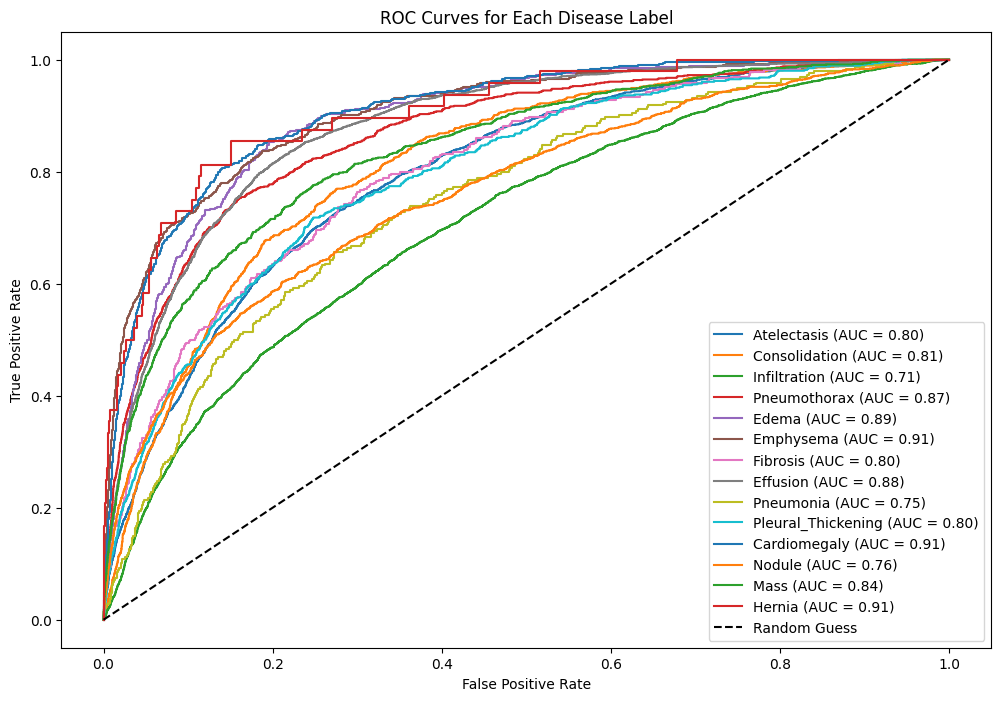

In [ ]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

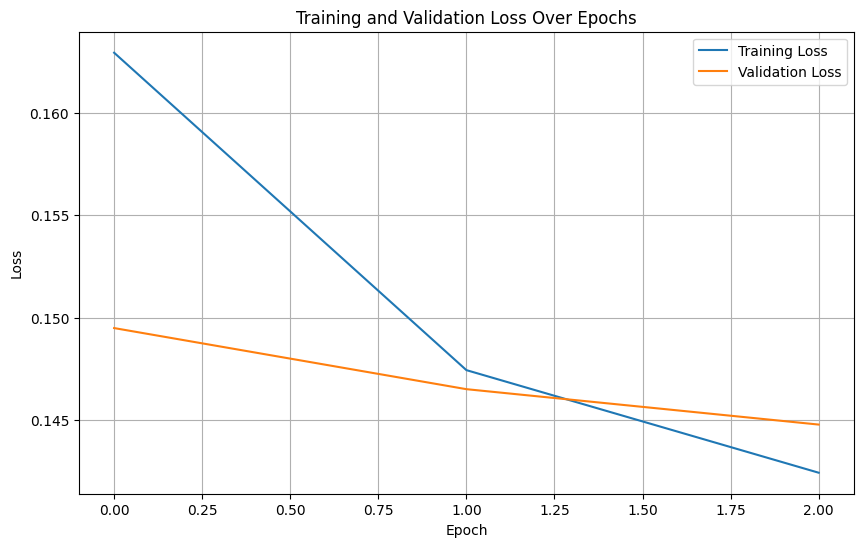

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

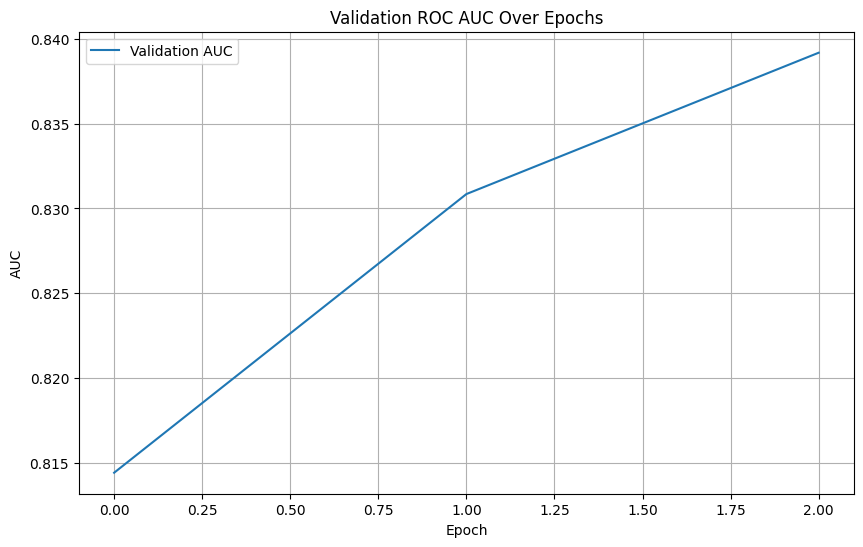

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()